In [1]:
# Import Libraries
import sys
from tqdm import tqdm, trange

import random
import numpy as np
import pandas as pd
from numba import njit
import scipy

from matplotlib import pyplot as plt

import torch
from torch.utils.data import TensorDataset
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
from activations import get_activations

import models as models
from models import MLP
import simulate


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")
device = torch.device("cpu")

plot_path = "/home/loek/projects/rnn/DNN/plots/mnist/"

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


GPU available


In [2]:
def blobs(device, N_datapoints=(10, 10), N_pixels=(10, 10)):
    """2d dataset of N_x * N_Y gaussian blobs."""
    x, y = np.linspace(-1, 1, N_pixels[0]), np.linspace(-1, 1, N_pixels[1])
    x, y = np.meshgrid(x, y)

    ## Generate blobs
    inputs, outputs_x, outputs_y = [], [], []
    for mu_x in np.linspace(-1, 1, N_datapoints[0]):
        for mu_y in np.linspace(-1, 1, N_datapoints[1]):
            gaussian = np.exp(-((x - mu_x) ** 2 + (y - mu_y) ** 2) / 2)
            inputs.append(gaussian.ravel())
            outputs_x.append(mu_x)
            outputs_y.append(mu_y)
    inputs = torch.tensor(inputs, device=device, dtype=torch.float32)
    outputs_x = torch.tensor(outputs_x, device=device, dtype=torch.float32)
    outputs_y = torch.tensor(outputs_y, device=device, dtype=torch.float32)

    ## Add context variable
    inputs_x = torch.concatenate((inputs, torch.zeros((inputs.shape[0], 1))), axis=1)
    inputs_y = torch.concatenate((inputs, torch.ones((inputs.shape[0], 1))), axis=1)
    inputs = torch.concatenate((inputs_x, inputs_y))
    outputs = torch.concatenate((outputs_x, outputs_y))

    dataset = TensorDataset(inputs, outputs)

    return dataset

In [3]:
# Load the data
encoding = Direct()
pixels = 5
N_data = 10
input_size = pixels * pixels

data = blobs(device, N_datapoints=(N_data, N_data), N_pixels=(pixels, pixels))

train_datasets = [data]
tracked_datasets = train_datasets

analyzed_data = data
labels = data.tensors[1]
inputs = data.tensors[0]
context = inputs[:, -1]
feature_x = np.concatenate(
    (labels[: int(len(inputs) / 2)], labels[: int(len(inputs) / 2)])
)
feature_y = np.concatenate(
    (labels[int(len(inputs) / 2) :], labels[int(len(inputs) / 2) :])
)

/tmp/ipykernel_18133/4005387621.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699077277992/work/torch/csrc/utils/tensor_new.cpp:245.)
  inputs = torch.tensor(inputs, device=device, dtype=torch.float32)


In [4]:
## Load settings
settings = "low_init"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/orthogonal.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)
nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [5]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=data.tensors[0].shape[1],
    output_size=1,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [6]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][int(len(model) / 2)],
        datasets=[analyzed_data],
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=[analyzed_data]
    ),
}

In [7]:
D0 = 0
DY = 0
for input, output in analyzed_data:
    x_norm = np.linalg.norm(input.cpu())
    y_norm = np.linalg.norm(model(input)[0].detach().cpu())
    D0 += (y_norm / x_norm) / len(analyzed_data)
print(f"D0 = {D0}")

hid_act_0 = get_activations(
    [analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding
)
out_act_0 = get_activations([analyzed_data], lambda x: model(x)[0], encoding)

D0 = 7.286739527495895e-11


In [8]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=64
)

Training: 100%|██████████| 10000/10000 [04:12<00:00, 39.60steps/s, train_loss=0.09296, val_loss=0.10694]


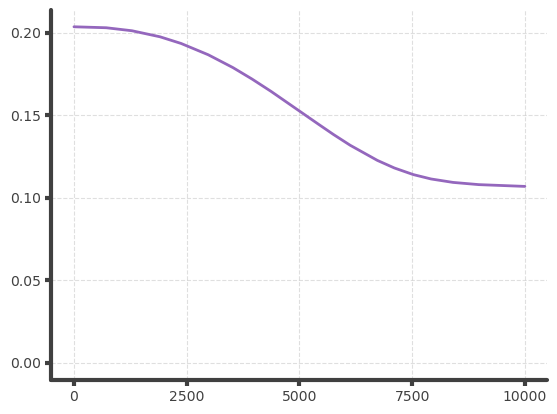

In [9]:
## Plot loss
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
data_hid = data_hid.copy()
data_output = data_output.copy()

loss = compiler.trackers["loss"].get_trace()
train_loss = loss.query("Dataset==0").groupby("Epoch").mean()
epochs = list(set(train_loss.index.get_level_values("Epoch")))

# animation = SliderAnimation(
#     {
#         # "Hidden representations": ActivationsAnimation(
#         #     data_hid, transform="PCA", plot_labels=True
#         # ),
#         # "Output": ActivationsAnimation(
#         #     data_output,
#         #     transform="none",
#         #     plot_labels=True,
#         #     # fixed_points=dict(zip(names, outputs)),
#         # ),
#         "Loss": EpochAnimation(
#             graphs={
#                 "Training loss": train_loss,
#                 "Validation loss": val_loss,
#             },
#             unitless_graphs={},
#             y_bounds=(0, 1),
#         ),
#     },
#     parameters=epochs,
#     parameter_name="Epoch",
#     fig_size=4,
# )

plt.plot(0, 0)
plt.plot(0, 0)
plt.plot(0, 0)
plt.plot(0, 0)
plt.plot(train_loss)
pub_show()

In [10]:
def plot(X, labels, colors="mixed"):
    fig = plt.figure(figsize=(3, 3))

    for output in np.unique(labels):
        x_red_digit = X[labels == output]
        plt.scatter(x_red_digit[:, 0], x_red_digit[:, 1])

    plt.gca().spines[["right", "top", "left", "bottom"]].set_visible(False)
    plt.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        right=False,
        top=False,
        labelbottom=False,
        labelleft=False,
    )

    if save:
        pub_show(colors=colors, save_path=plot_path + "pca/" + "inputs")
    else:
        pub_show(colors=colors)

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


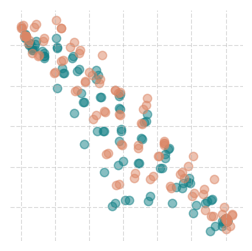

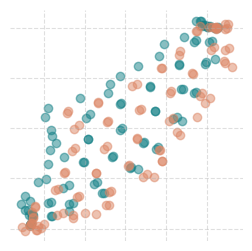

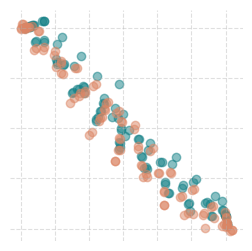

In [11]:
## PCA representations
import sklearn

save = False


h = data_hid.query(f"Epoch == {epochs[-1]}").to_numpy()
x = inputs

h_red = sklearn.manifold.MDS(n_components=3).fit_transform(h)
x_red = sklearn.manifold.MDS(n_components=3).fit_transform(x)

# h_red = sklearn.decomposition.PCA(n_components=3).fit_transform(h)
# x_red = sklearn.decomposition.PCA(n_components=3).fit_transform(x)


plot(h_red[:, [0, 1]], context, colors="mixed")
plot(h_red[:, [1, 2]], context, colors="mixed")
plot(h_red[:, [0, 2]], context, colors="mixed")

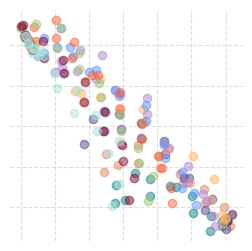

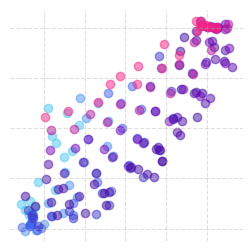

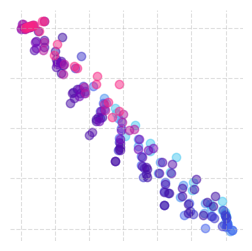

In [14]:
plot(h_red[:, [0, 1]], feature_x, colors="gradient")
plot(h_red[:, [1, 2]], feature_x, colors="gradient")
plot(h_red[:, [0, 2]], feature_x, colors="gradient")

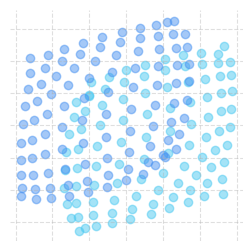

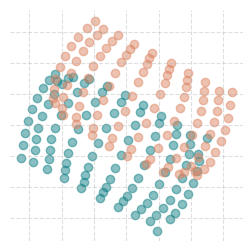

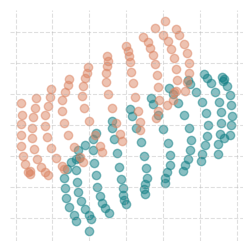

In [15]:
plot(x_red[:, [0, 1]], context, colors="mixed")
plot(x_red[:, [1, 2]], context, colors="mixed")
plot(x_red[:, [0, 2]], context, colors="mixed")